In [ ]:
import findspark
findspark.init()

In [ ]:
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
import string
from PIL import Image
from wordcloud import WordCloud

import pyspark
from pyspark.sql import SparkSession
from pyspark.sql.functions import *
from pyspark.ml import Pipeline
from pyspark.ml.feature import StandardScaler, VectorAssembler
from pyspark.ml.feature import CountVectorizer, IDF, StopWordsRemover, Tokenizer
from pyspark.ml.clustering import KMeans
from pyspark.ml.evaluation import ClusteringEvaluator
from pyspark.sql import Row
from pyspark.ml.linalg import Vectors

import warnings
warnings.filterwarnings("ignore")

In [ ]:
spark = SparkSession.builder.appName('Movies').getOrCreate()

# <font color='Mediumblue'>Table Contents</font> </br>

<details>
    <summary>Click for details</summary>


1. [Overview about data](#overview) <br/> <br />

2. [Pre-process data](#preprocess) <br /> <br />

    2.1. [Check NaN and Null values](#NullNaN)
    
    2.2. [Transform data](#transform)
    
<br>

3. [Clustering](#cluster) <br /> <br />
    
4. [Word cloud](#visual)

<br>     
</details>

## <a name="overview">1. Overview about data</a>

In [ ]:
data = spark.read.option("header", "true")\
                 .option("quote", "\"")\
                 .option("escape", "\"")\
                 .csv('tmdb_5000_movies.csv')

In [ ]:
data.count()

4806

In [ ]:
data.printSchema()

root
 |-- budget: string (nullable = true)
 |-- genres: string (nullable = true)
 |-- homepage: string (nullable = true)
 |-- id: string (nullable = true)
 |-- keywords: string (nullable = true)
 |-- original_language: string (nullable = true)
 |-- original_title: string (nullable = true)
 |-- overview: string (nullable = true)
 |-- popularity: string (nullable = true)
 |-- production_companies: string (nullable = true)
 |-- production_countries: string (nullable = true)
 |-- release_date: string (nullable = true)
 |-- revenue: string (nullable = true)
 |-- runtime: string (nullable = true)
 |-- spoken_languages: string (nullable = true)
 |-- status: string (nullable = true)
 |-- tagline: string (nullable = true)
 |-- title: string (nullable = true)
 |-- vote_average: string (nullable = true)
 |-- vote_count: string (nullable = true)



In [ ]:
data = data.select(['title', 'tagline', 'overview', 'genres', 'popularity'])

In [ ]:
data.show(5)

+--------------------+--------------------+--------------------+--------------------+----------+
|               title|             tagline|            overview|              genres|popularity|
+--------------------+--------------------+--------------------+--------------------+----------+
|              Avatar|Enter the World o...|In the 22nd centu...|[{"id": 28, "name...|150.437577|
|Pirates of the Ca...|At the end of the...|Captain Barbossa,...|[{"id": 12, "name...|139.082615|
|             Spectre|A Plan No One Esc...|A cryptic message...|[{"id": 28, "name...|107.376788|
|The Dark Knight R...|     The Legend Ends|Following the dea...|[{"id": 28, "name...| 112.31295|
|         John Carter|Lost in our world...|John Carter is a ...|[{"id": 28, "name...| 43.926995|
+--------------------+--------------------+--------------------+--------------------+----------+
only showing top 5 rows



## <a name="preprocess">2. Pre-process data</a>

####  <a name="NullNan">2.1 Check NaN and Null values</a>

In [ ]:
data.select([count(when(col(c).isNull(), c)).alias(c) for c in data.columns]).show()

+-----+-------+--------+------+----------+
|title|tagline|overview|genres|popularity|
+-----+-------+--------+------+----------+
|    5|    848|       3|     0|         3|
+-----+-------+--------+------+----------+



In [ ]:
data.select([count(when(isnan(col(c)), c)).alias(c) for c in data.columns]).show()

+-----+-------+--------+------+----------+
|title|tagline|overview|genres|popularity|
+-----+-------+--------+------+----------+
|    0|      0|       0|     0|         0|
+-----+-------+--------+------+----------+



In [ ]:
data = data.fillna('', subset = 'tagline')
data = data.withColumn('description', concat_ws(' ', col('title'), col('tagline'), col('overview')))
data = data.dropna()

In [ ]:
data.select([count(when(col(c).isNull(), c)).alias(c) for c in data.columns]).show()

+-----+-------+--------+------+----------+-----------+
|title|tagline|overview|genres|popularity|description|
+-----+-------+--------+------+----------+-----------+
|    0|      0|       0|     0|         0|          0|
+-----+-------+--------+------+----------+-----------+



In [ ]:
data.count()

4798

In [ ]:
data.show()

+--------------------+--------------------+--------------------+--------------------+----------+--------------------+
|               title|             tagline|            overview|              genres|popularity|         description|
+--------------------+--------------------+--------------------+--------------------+----------+--------------------+
|              Avatar|Enter the World o...|In the 22nd centu...|[{"id": 28, "name...|150.437577|Avatar Enter the ...|
|Pirates of the Ca...|At the end of the...|Captain Barbossa,...|[{"id": 12, "name...|139.082615|Pirates of the Ca...|
|             Spectre|A Plan No One Esc...|A cryptic message...|[{"id": 28, "name...|107.376788|Spectre A Plan No...|
|The Dark Knight R...|     The Legend Ends|Following the dea...|[{"id": 28, "name...| 112.31295|The Dark Knight R...|
|         John Carter|Lost in our world...|John Carter is a ...|[{"id": 28, "name...| 43.926995|John Carter Lost ...|
|        Spider-Man 3|  The battle within.|The seemingly

#### <a name="NLP">2.2 Feature Transformations</a>

In [ ]:
def cleaning_text(data, col_name):
    '''
    This function helps to:
        1. Remove all singular letters except 'a'.
        2. Expand all words with contractions.('re -> are).
        3. Remove all special character (#!?, ...)
        4. Remove all extra spaces.
        5. Lowcase text.

        Params:
            data: pyspark.DataFrame
            col_name: name columns to clean

        Return:
            Data cleaned
    '''
    alphabet = list(string.ascii_lowercase)
    alphabet = alphabet[1:]

    for letter in alphabet:
        data = data.withColumn(col_name, regexp_replace(col_name, ' '+letter+' ', ' '))

    data = data.withColumn(col_name, regexp_replace(col_name, ' re', 'are'))\
               .withColumn(col_name, regexp_replace(col_name, ' ve', 'have'))\
               .withColumn(col_name, regexp_replace(col_name, ' ll', 'will'))\
               .withColumn(col_name, regexp_replace(col_name, '[^\w\s]+', ''))\
               .withColumn(col_name, regexp_replace(col_name, '[@\+\#\$\%\^\!]+', ''))

    data = data.withColumn(col_name, regexp_replace(col_name, '\s+', ' '))

    data = data.withColumn(col_name, lower(data[col_name]))

    return data

Clean text in description column

In [ ]:
data = cleaning_text(data, 'description')
data.show()

+--------------------+--------------------+--------------------+--------------------+----------+--------------------+
|               title|             tagline|            overview|              genres|popularity|         description|
+--------------------+--------------------+--------------------+--------------------+----------+--------------------+
|              Avatar|Enter the World o...|In the 22nd centu...|[{"id": 28, "name...|150.437577|avatar enter the ...|
|Pirates of the Ca...|At the end of the...|Captain Barbossa,...|[{"id": 12, "name...|139.082615|pirates of the ca...|
|             Spectre|A Plan No One Esc...|A cryptic message...|[{"id": 28, "name...|107.376788|spectre a plan no...|
|The Dark Knight R...|     The Legend Ends|Following the dea...|[{"id": 28, "name...| 112.31295|the dark knight r...|
|         John Carter|Lost in our world...|John Carter is a ...|[{"id": 28, "name...| 43.926995|john carter lost ...|
|        Spider-Man 3|  The battle within.|The seemingly

In [ ]:
data.printSchema()

root
 |-- title: string (nullable = true)
 |-- tagline: string (nullable = false)
 |-- overview: string (nullable = true)
 |-- genres: string (nullable = true)
 |-- popularity: string (nullable = true)
 |-- description: string (nullable = false)



Casting the popularity from string to double

In [ ]:
data = data.withColumn("popularity", data.popularity.cast('double'))
data = data.dropna()

In [ ]:
data.printSchema()

root
 |-- title: string (nullable = true)
 |-- tagline: string (nullable = false)
 |-- overview: string (nullable = true)
 |-- genres: string (nullable = true)
 |-- popularity: double (nullable = true)
 |-- description: string (nullable = false)



In [ ]:
data.show()

+--------------------+--------------------+--------------------+--------------------+----------+--------------------+
|               title|             tagline|            overview|              genres|popularity|         description|
+--------------------+--------------------+--------------------+--------------------+----------+--------------------+
|              Avatar|Enter the World o...|In the 22nd centu...|[{"id": 28, "name...|150.437577|avatar enter the ...|
|Pirates of the Ca...|At the end of the...|Captain Barbossa,...|[{"id": 12, "name...|139.082615|pirates of the ca...|
|             Spectre|A Plan No One Esc...|A cryptic message...|[{"id": 28, "name...|107.376788|spectre a plan no...|
|The Dark Knight R...|     The Legend Ends|Following the dea...|[{"id": 28, "name...| 112.31295|the dark knight r...|
|         John Carter|Lost in our world...|John Carter is a ...|[{"id": 28, "name...| 43.926995|john carter lost ...|
|        Spider-Man 3|  The battle within.|The seemingly

In [ ]:
tokenizer1 = Tokenizer(inputCol="description", outputCol="token_description")

stopremove1 = StopWordsRemover(inputCol='token_description',outputCol='stop_tokens_des')

count_vec1 = CountVectorizer(inputCol='stop_tokens_des', outputCol='c_vec_des', )

idf1 = IDF(inputCol="c_vec_des", outputCol="idf_des")

In [ ]:
vec_assembler = VectorAssembler(inputCols = ['idf_des', 'popularity'], outputCol='features')

In [ ]:
scaler = StandardScaler(inputCol="features",
                        outputCol="scaledFeatures",
                        withStd=True,
                        withMean=False)

In [ ]:
data_prep_pipe = Pipeline(stages = [tokenizer1, stopremove1, count_vec1, idf1, vec_assembler, scaler])
cleaner = data_prep_pipe.fit(data)

clean_data = cleaner.transform(data)

In [ ]:
clean_data.select('scaledFeatures').show(3)

+--------------------+
|      scaledFeatures|
+--------------------+
|(26906,[3,33,86,3...|
|(26906,[0,3,14,55...|
|(26906,[1,14,60,8...|
+--------------------+
only showing top 3 rows



## <a name="cluster">3. Clustering </a>

In [ ]:
silhouette_scores = []
for k in range(2,10):
    kmeans = KMeans(featuresCol='scaledFeatures', k=k)

    model = kmeans.fit(clean_data)

    predictions = model.transform(clean_data)

    evaluator = ClusteringEvaluator(featuresCol='scaledFeatures', predictionCol='prediction')
    silhouette_score = evaluator.evaluate(predictions)

    silhouette_scores.append(silhouette_score)
    print(f"Silhouette Score: {silhouette_score}, for k= {k}")

Silhouette Score: 0.34388835631583087, for k= 2
Silhouette Score: -0.017453641139136496, for k= 3
Silhouette Score: -0.019149912583642927, for k= 4
Silhouette Score: -0.017400140034933224, for k= 5
Silhouette Score: -0.221983944684971, for k= 6
Silhouette Score: -0.018998945163507655, for k= 7
Silhouette Score: -0.22191602686690445, for k= 8
Silhouette Score: -0.01932057500462237, for k= 9


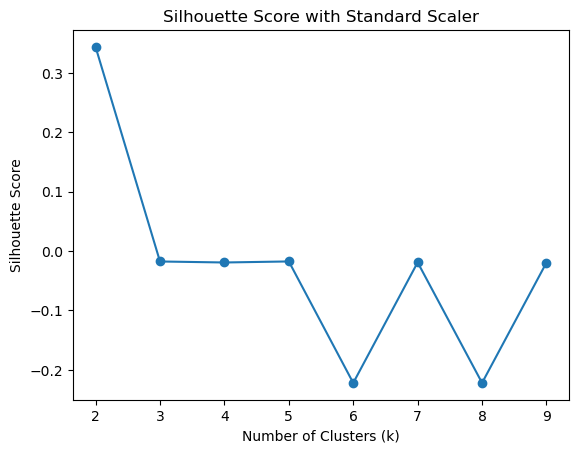

In [ ]:
plt.plot(range(2, 10), silhouette_scores, marker='o')
plt.title('Silhouette Score with Standard Scaler')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Silhouette Score')
plt.show()

#### Choose k = 3

In [ ]:
kmeans = KMeans(featuresCol='scaledFeatures', k=3)
model = kmeans.fit(clean_data)

In [ ]:
centers = model.clusterCenters()
print("Cluster Centers: ")
for center in centers:
    print(center)

Cluster Centers: 
[0.40563136 0.42244686 0.38676984 ... 0.0144775  0.0144775  0.67373462]
[0.         0.45000797 0.         ... 0.         0.         0.52143678]
[0.         0.         0.57249595 ... 0.         0.         3.64589801]


In [ ]:
predictions = model.transform(clean_data)

In [ ]:
cluster_characteristics = predictions.groupBy("prediction").agg(
    {"popularity": "mean"}
).orderBy("prediction")


## <a name="visual">4. Word Cloud </a>

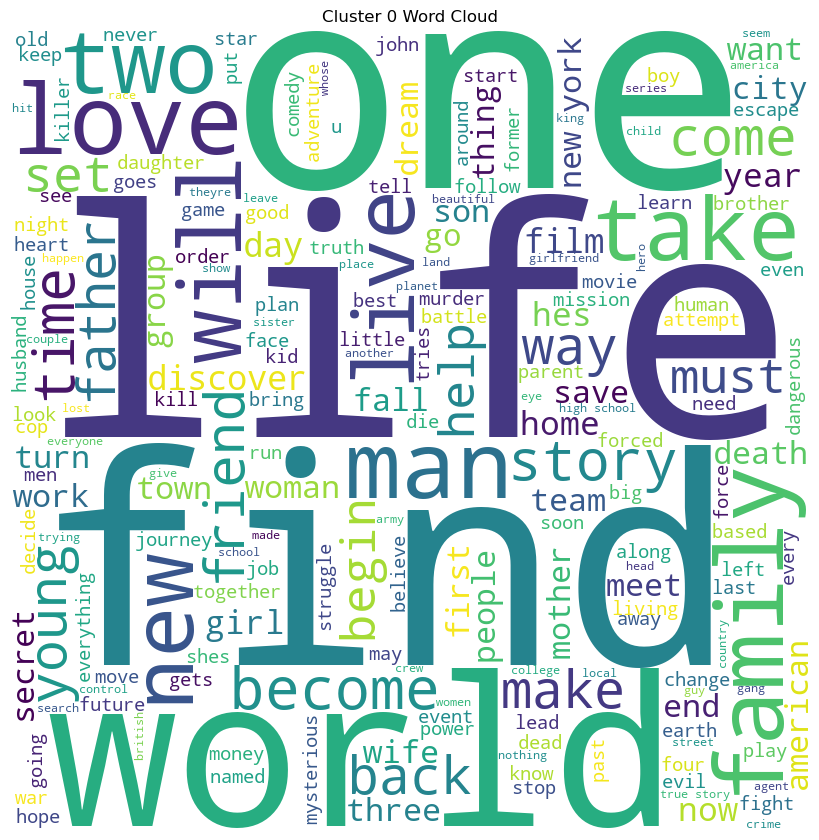

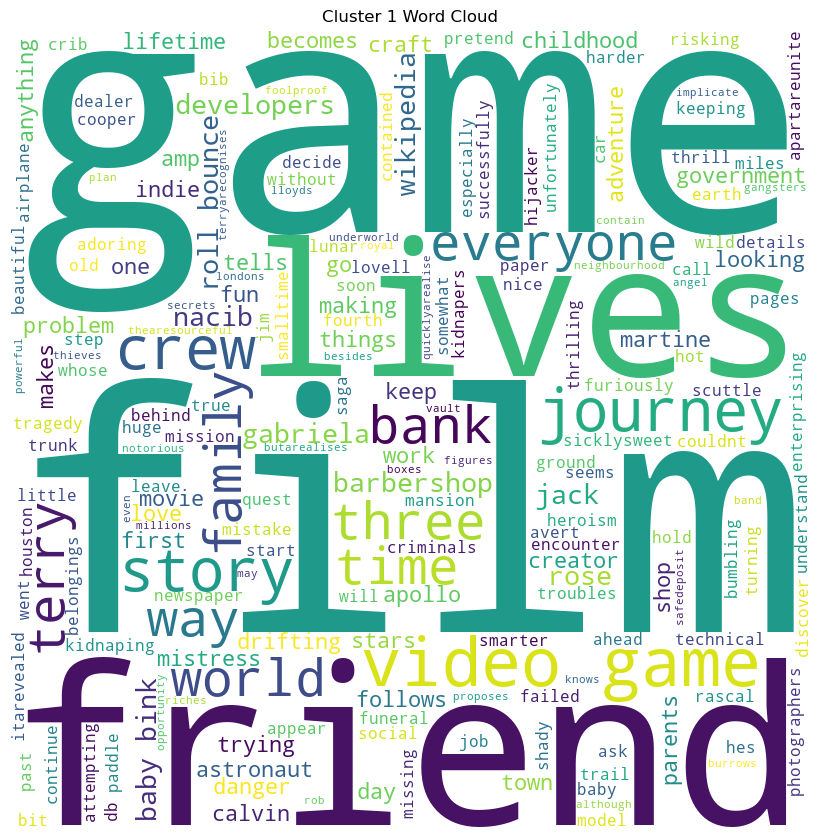

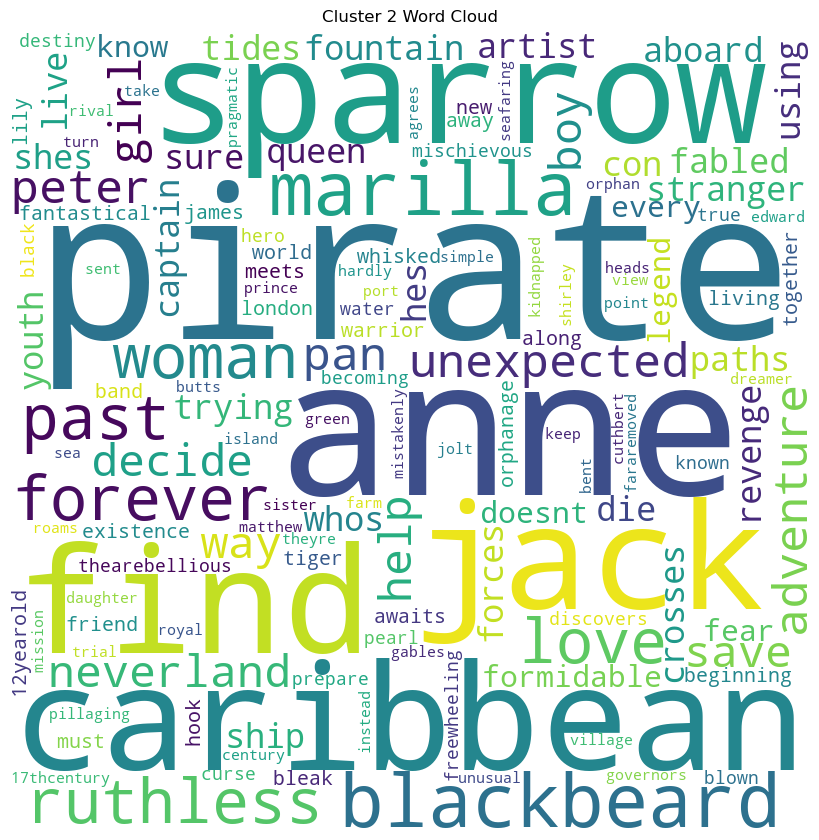

In [ ]:
def generate_wordcloud(text):
    wordcloud = WordCloud(width=800, height=800, background_color='white', min_font_size=10).generate(text)
    return wordcloud

for cluster_id in range(3):
    cluster_text = ' '.join(predictions.filter(col('prediction') == cluster_id).select('description').rdd.flatMap(lambda x: x).collect())

    wordcloud = generate_wordcloud(cluster_text)

    plt.figure(figsize=(8, 8), facecolor=None)
    plt.imshow(wordcloud)
    plt.axis("off")
    plt.tight_layout(pad=0)
    plt.title(f'Cluster {cluster_id} Word Cloud')
    plt.show()